# San Diego Data Digest - Feb. 28, 2024

In [1]:
import pandas as pd
mls = pd.concat([pd.read_csv("./raw/housingwire___datadigest___mls_v1.csv"),
                pd.read_csv("./raw/housingwire___datadigest___mls_v2.csv")])
vls = pd.read_csv("./raw/housingwire___datadigest___vls.csv")
mma = pd.read_csv("./raw/housingwire___datadigest___mma.csv")

## Sales and Listings

In [2]:
mls.info()

<class 'pandas.core.frame.DataFrame'>
Index: 847000 entries, 0 to 423501
Data columns (total 8 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   geographic                           847000 non-null  object 
 1   listing_office_name                  840919 non-null  object 
 2   listing_office_id                    839921 non-null  object 
 3   listing_year                         847000 non-null  int64  
 4   total_listings                       847000 non-null  int64  
 5   avg_price_per_square_foot            822686 non-null  float64
 6   avg_derived_days_on_market           844816 non-null  float64
 7   avg_sales_price_to_list_price_ratio  760118 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 58.2+ MB


In [3]:
mls.listing_office_name.fillna("", inplace=True)
mls["listing_office_name"] = mls.listing_office_name.str.upper()

In [4]:
mls.head()

,geographic,listing_office_name,listing_office_id,listing_year,total_listings,avg_price_per_square_foot,avg_derived_days_on_market,avg_sales_price_to_list_price_ratio
0,Rest of US,INHABIT REAL ESTATE GROUP,3681,2020,178,140.457829,105.937853,0.976497
1,Rest of US,SKOGMAN REALTY,CSKN,2021,804,134.244628,68.004981,1.002148
2,Rest of US,COLDWELL BANKER HEDGES,CHED01,2021,467,119.531338,33.927039,0.990944
3,Rest of US,"OLYMPIAN PROPERTIES, LLC",OLPR01,2019,12,143.212500,121.916667,0.947409
4,Rest of US,JOYNER FINE PROPERTIES,JOYN05,2022,34,253.066667,10.705882,1.073869


In [5]:
mls[['geographic', 'listing_year', 'total_listings']].groupby(['geographic', 'listing_year']).sum().reset_index()\
    .to_excel('./cleaned/Listings per Year.xlsx', index=False)

In [6]:
print("US:")
print("2019:", len(mls.loc[mls.listing_year==2019, 'listing_office_id'].unique()))
print("2023:", len(mls.loc[mls.listing_year==2023, 'listing_office_id'].unique()))

print("San Diego:")
print("2019:", len(mls.loc[(mls.listing_year==2019)&(mls.geographic=="San Diego"), 'listing_office_id'].unique()))
print("2023:", len(mls.loc[(mls.listing_year==2023)&(mls.geographic=="San Diego"), 'listing_office_id'].unique()))


US:
2019: 147613
2023: 123681
San Diego:
2019: 10054
2023: 6449


In [7]:
stats_by_geo = \
mls.drop(columns=['listing_office_name', 'listing_office_id'])\
    .groupby(['listing_year', 'geographic'])\
        .agg({'total_listings':'sum', 
              'avg_price_per_square_foot':'mean',
              'avg_derived_days_on_market':'mean',
              'avg_sales_price_to_list_price_ratio':'mean'})
pd.pivot_table(stats_by_geo.reset_index(), columns="geographic", index="listing_year", 
               values=["avg_price_per_square_foot", "avg_derived_days_on_market",
                       "avg_sales_price_to_list_price_ratio"])\
.to_excel('./cleaned/City, State, Country.xlsx')

In [8]:
def byOfficeByYear(year):
    by_office = mls.loc[(mls.listing_year==year)&(mls.geographic=='San Diego'), 
                        ['listing_office_id', 'total_listings']]\
                        .groupby('listing_office_id').sum()\
                        .sort_values('total_listings', ascending=False)
    by_office["perc_listings"] = by_office.total_listings / mls[(mls.listing_year==year)&(mls.geographic=='San Diego')].total_listings.sum() * 100
    by_office["bin"] = None 
    by_office.iloc[:10].loc[:, "bin"] = "Top 10"
    by_office.iloc[10:100].loc[:, "bin"] = "11-100"
    by_office.iloc[100:500].loc[:, "bin"] = "101-500"
    by_office.iloc[500:].loc[:, "bin"] = "All other offices"
    return by_office

_2023 = byOfficeByYear(2023)
_2022 = byOfficeByYear(2022)
_2021 = byOfficeByYear(2021)
_2020 = byOfficeByYear(2020)
_2019 = byOfficeByYear(2019)

_2019[["bin", "perc_listings"]].groupby("bin").sum().reset_index().rename(columns={"perc_listings":"2019"})\
.merge(
    _2020[["bin", "perc_listings"]].groupby("bin").sum().reset_index().rename(columns={"perc_listings":"2020"}),
    on="bin"
)\
.merge(
    _2021[["bin", "perc_listings"]].groupby("bin").sum().reset_index().rename(columns={"perc_listings":"2021"}),
    on="bin"
)\
.merge(
    _2022[["bin", "perc_listings"]].groupby("bin").sum().reset_index().rename(columns={"perc_listings":"2022"}),
    on="bin"
)\
.merge(
    _2023[["bin", "perc_listings"]].groupby("bin").sum().reset_index().rename(columns={"perc_listings":"2023"}),
    on="bin"
).to_excel("./cleaned/Listing Share by Office Bins.xlsx", index=False)

In [9]:
new_names = [
    "Coldwell Banker", "Century 21", "Redfin ", "Keller Williams", "eXp ", "HomeSmart", "Big Block Realty", "Compass", "RE/MAX",
    "Berkshire Hathaway", "Opendoor", "Realty One"
]

def change_name(old_name):
    for name in new_names:
        if old_name.startswith(name.upper()):
            return name.upper()
    return old_name
    
mls["listing_office_group"] = mls.listing_office_name.apply(lambda x: change_name(x))

In [10]:
def groupedByYear(year):
        grouped = mls.loc[(mls.listing_year==year)&(mls.geographic=='San Diego'), 
                ]\
                .groupby('listing_office_group').agg({
                        'listing_office_id':'unique',
                        'total_listings':'sum',
                        'avg_price_per_square_foot':'mean',
                        'avg_derived_days_on_market':'mean',
                        'avg_sales_price_to_list_price_ratio':'mean'
                })\
                .sort_values('total_listings', ascending=False).head(50)
        grouped["listing_office_id"] = [len(x) for x in grouped.listing_office_id]
        grouped["perc_listings"] = grouped.total_listings / mls[(mls.listing_year==year)&(mls.geographic=='San Diego')].total_listings.sum() * 100
        grouped["listing_year"] = year
        grouped.rename(columns={"listing_office_id":"unique_offices"}, inplace=True)
        return grouped

_2023 = groupedByYear(2023)
_2022 = groupedByYear(2022)
_2021 = groupedByYear(2021)
_2020 = groupedByYear(2020)
_2019 = groupedByYear(2019)

In [11]:
top_by_listings = \
_2019.reset_index()[['listing_office_group', 'total_listings']].rename(columns={'total_listings':'2019'})\
    .merge(
        _2020.reset_index()[['listing_office_group', 'total_listings']].rename(columns={'total_listings':'2020'}),
        on='listing_office_group', how='outer'
    )\
    .merge(
        _2021.reset_index()[['listing_office_group', 'total_listings']].rename(columns={'total_listings':'2021'}),
        on='listing_office_group', how='outer'
    )\
    .merge(
        _2022.reset_index()[['listing_office_group', 'total_listings']].rename(columns={'total_listings':'2022'}),
        on='listing_office_group', how='outer'
    )\
    .merge(
        _2023.reset_index()[['listing_office_group', 'total_listings']].rename(columns={'total_listings':'2023'}),
        on='listing_office_group', how='outer'
    )


In [12]:
_2023.to_excel('./cleaned/2023 By Co.xlsx')
top_by_listings.to_excel('./cleaned/Top by Listings Annualy.xlsx', index=False)

## Equity and Liens

In [13]:
vls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   geographic                3 non-null      object 
 1   avg_estimated_value_mktg  3 non-null      float64
 2   avg_estimated_equity      3 non-null      float64
dtypes: float64(2), object(1)
memory usage: 204.0+ bytes


   geographic  avg_estimated_value_mktg  avg_estimated_equity
0  Rest of US              4.236455e+05         236289.166340
1  Rest of CA              9.519089e+05         614589.524749
2   San Diego              1.102047e+06         730398.322141


<Axes: xlabel='geographic'>

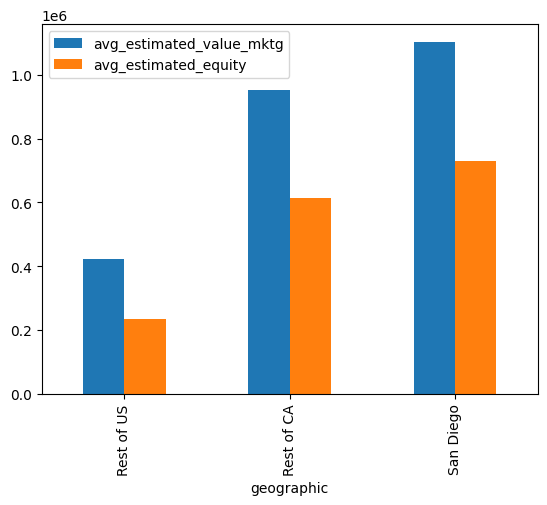

In [14]:
print(vls)
vls.set_index("geographic").plot(kind="bar")

## Mortgage Info

In [15]:
mma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341 entries, 0 to 340
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   geographic                    341 non-null    object
 1   year                          341 non-null    int64 
 2   cash_purchase_indicator       341 non-null    int64 
 3   mortgage_purchase_indicator   341 non-null    int64 
 4   investor_purchase_indicator   341 non-null    int64 
 5   new_construction_indicator    341 non-null    int64 
 6   conforming_loan_indicator     341 non-null    int64 
 7   nonconforming_loan_indicator  341 non-null    int64 
 8   mortgage_loan_type_code       285 non-null    object
 9   transactions                  341 non-null    int64 
dtypes: int64(8), object(2)
memory usage: 26.8+ KB


In [16]:
mma.describe()

,year,cash_purchase_indicator,mortgage_purchase_indicator,investor_purchase_indicator,new_construction_indicator,conforming_loan_indicator,nonconforming_loan_indicator,transactions
count,341.000000,341.000000,341.000000,341.0,341.000000,341.000000,341.000000,3.410000e+02
mean,2021.014663,0.035191,0.645161,0.0,0.395894,0.111437,0.120235,5.691886e+04
std,1.406839,0.184532,0.479168,0.0,0.489761,0.315135,0.325714,2.759841e+05
min,2019.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000e+00
25%,2020.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,7.000000e+00
50%,2021.000000,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.400000e+02
75%,2022.000000,0.000000,1.000000,0.0,1.000000,0.000000,0.000000,5.932000e+03
max,2023.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,2.591811e+06


In [17]:
mma.loc[mma.cash_purchase_indicator==1, ['geographic', 'year', 'transactions']].groupby(['geographic', 'year']).sum()

transactions
geographic year              
Rest of US 2021             1
           2022            26
           2023            44

In [18]:
mma.drop(columns=['investor_purchase_indicator', 'cash_purchase_indicator'], inplace=True)

In [19]:
mma.head()

,geographic,year,mortgage_purchase_indicator,new_construction_indicator,conforming_loan_indicator,nonconforming_loan_indicator,mortgage_loan_type_code,transactions
0,Rest of US,2022,1,0,1,0,CNV,2166091
1,Rest of US,2023,1,0,1,0,CNV,1686047
2,Rest of US,2023,1,0,0,0,VA,196325
3,Rest of CA,2020,1,0,0,0,FHA,42607
4,Rest of US,2020,1,1,0,1,CNV,10598


In [20]:
mma.describe()

,year,mortgage_purchase_indicator,new_construction_indicator,conforming_loan_indicator,nonconforming_loan_indicator,transactions
count,341.000000,341.000000,341.000000,341.000000,341.000000,3.410000e+02
mean,2021.014663,0.645161,0.395894,0.111437,0.120235,5.691886e+04
std,1.406839,0.479168,0.489761,0.315135,0.325714,2.759841e+05
min,2019.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,2020.000000,0.000000,0.000000,0.000000,0.000000,7.000000e+00
50%,2021.000000,1.000000,0.000000,0.000000,0.000000,1.400000e+02
75%,2022.000000,1.000000,1.000000,0.000000,0.000000,5.932000e+03
max,2023.000000,1.000000,1.000000,1.000000,1.000000,2.591811e+06


In [21]:
len(mma[mma.mortgage_purchase_indicator == 0]) / len(mma)

0.3548387096774194

In [22]:
purchase = mma.loc[mma.mortgage_purchase_indicator==1, 
                   ["year", "geographic", "mortgage_loan_type_code", "conforming_loan_indicator", "nonconforming_loan_indicator", "transactions"]
                ]
len(purchase), purchase.conforming_loan_indicator.sum() + purchase.nonconforming_loan_indicator.sum()

(220, 61)

In [23]:
purchase.mortgage_loan_type_code.fillna("Unknown", inplace=True)
purchase["mortgage_loan_type_code"] = purchase.mortgage_loan_type_code.str.upper().replace('N', 'Unknown').replace('UNKNOWN', 'Unknown')
purchase.mortgage_loan_type_code.value_counts()

mortgage_loan_type_code
CNV        78
VA         34
FHA        32
PP         30
Unknown    29
SBA        17
Name: count, dtype: int64

In [24]:
purchase.loc[(purchase.conforming_loan_indicator==0)&(purchase.nonconforming_loan_indicator==0), ['mortgage_loan_type_code', 'transactions']]\
.groupby('mortgage_loan_type_code').sum()

,transactions
mortgage_loan_type_code,
CNV,675
FHA,2811051
PP,515750
SBA,886
Unknown,321973
VA,1523240


In [25]:
purchase.loc[(purchase.conforming_loan_indicator==0)&(purchase.nonconforming_loan_indicator==0)&(purchase.mortgage_loan_type_code.isin(["FHA", "VA"])),
              'conforming_loan_indicator'] = 1
purchase.drop(columns="nonconforming_loan_indicator", inplace=True)

In [26]:
conforming = purchase.drop(columns="mortgage_loan_type_code").groupby(["geographic", "year", "conforming_loan_indicator"]).sum().reset_index()
conforming["conforming_loan_indicator"] = ["Conforming" if x == 1 else "Nonconforming" for x in conforming.conforming_loan_indicator]
pd.pivot_table(conforming, index=["year", "geographic"], columns="conforming_loan_indicator", values="transactions").reset_index()\
.to_excel('./cleaned/Share Conforming.xlsx', index=False)

In [27]:
purchase_by_type = \
purchase.drop(columns='conforming_loan_indicator').groupby(['geographic', 'year', 'mortgage_loan_type_code']).sum().reset_index()

purchase_by_type

,geographic,year,mortgage_loan_type_code,transactions
0,Rest of CA,2019,CNV,257630
1,Rest of CA,2019,FHA,49341
2,Rest of CA,2019,PP,11043
3,Rest of CA,2019,SBA,35
4,Rest of CA,2019,Unknown,3419
...,...,...,...,...
81,San Diego,2023,CNV,14797
82,San Diego,2023,FHA,1700
83,San Diego,2023,PP,685
84,San Diego,2023,Unknown,437


In [28]:
pivoted = pd.pivot_table(purchase_by_type, index=['year', 'geographic'], values='transactions', columns='mortgage_loan_type_code').fillna(0).reset_index()
pivoted

mortgage_loan_type_code,year,geographic,CNV,FHA,PP,SBA,Unknown,VA
0,2019,Rest of CA,257630.0,49341.0,11043.0,35.0,3419.0,16748.0
1,2019,Rest of US,2508257.0,563580.0,94100.0,183.0,69900.0,288104.0
2,2019,San Diego,25183.0,2737.0,802.0,0.0,337.0,5079.0
3,2020,Rest of CA,269267.0,44964.0,10290.0,4.0,2901.0,17769.0
4,2020,Rest of US,2730812.0,566705.0,87036.0,96.0,67539.0,299249.0
5,2020,San Diego,26152.0,2459.0,699.0,0.0,292.0,6039.0
6,2021,Rest of CA,317345.0,41978.0,11450.0,63.0,4007.0,16294.0
7,2021,Rest of US,2982854.0,550125.0,91474.0,186.0,73140.0,301496.0
8,2021,San Diego,29601.0,2062.0,799.0,4.0,411.0,4917.0
9,2022,Rest of CA,232375.0,34346.0,9844.0,24.0,3436.0,13242.0


In [29]:
with_total = \
pivoted.merge(
    purchase[['year', 'geographic', 'transactions']].groupby(['year', 'geographic']).sum().reset_index(),
    on=["year", "geographic"]
).rename(columns={'transactions':'total'})
for col in ["CNV", "FHA", "PP", "SBA", "Unknown", "VA"]:
    with_total[col] = with_total[col] / with_total.total * 100
with_total

,year,geographic,CNV,FHA,PP,SBA,Unknown,VA,total
0,2019,Rest of CA,76.173215,14.588606,3.265073,0.010348,1.010892,4.951865,338216
1,2019,Rest of US,71.173914,15.992059,2.670167,0.005193,1.983472,8.175195,3524124
2,2019,San Diego,73.768235,8.017459,2.349288,0.000000,0.987170,14.877849,34138
3,2020,Rest of CA,78.004316,13.025681,2.980924,0.001159,0.840395,5.147525,345195
4,2020,Rest of US,72.793759,15.106345,2.320071,0.002559,1.800350,7.976917,3751437
5,2020,San Diego,73.376168,6.899357,1.961224,0.000000,0.819281,16.943969,35641
6,2021,Rest of CA,81.133976,10.732301,2.927363,0.016107,1.024449,4.165804,391137
7,2021,Rest of US,74.584869,13.755618,2.287265,0.004651,1.828831,7.538766,3999275
8,2021,San Diego,78.321956,5.455892,2.114092,0.010584,1.087474,13.010002,37794
9,2022,Rest of CA,79.236668,11.711512,3.356668,0.008184,1.171629,4.515339,293267


In [30]:
percs = with_total[["year", "geographic", "CNV", "FHA", "VA", "PP", "SBA", "Unknown"]].sort_values(by=["geographic", "year"])
percs["Other"] = percs["Unknown"] + percs["SBA"]
percs.drop(columns=["SBA","Unknown"], inplace=True)
percs.to_excel('./cleaned/Mortgages by Type.xlsx', index=False)